# Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount("/content/gdrive", force_remount=True)
# drive.flush_and_unmount()

Mounted at /content/gdrive


In [2]:
import os
workdir = os.getcwd()

In [3]:
# Shuyan
# dataset_path = '/content/gdrive/My Drive/Documents/University Documents/Fourth Year/APS360/APS360 Project/GTSRB_dataset/archive'
# Shihang
# dataset_path = '/content/gdrive/My Drive/APS360/APS360 Project/GTSRB_dataset/archive'
# Evelyn
dataset_path = '/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive'
# Zian
# dataset_path =

In [4]:
!cp -rv "$dataset_path" "$workdir"

Streaming output truncated to the last 5000 lines.
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/Updated_Train/35/00035_00033_00018.png' -> '/content/archive/Updated_Train/35/00035_00033_00018.png'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/Updated_Train/35/00035_00030_00007.png' -> '/content/archive/Updated_Train/35/00035_00030_00007.png'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/Updated_Train/35/00035_00029_00029.png' -> '/content/archive/Updated_Train/35/00035_00029_00029.png'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/Updated_Train/35/00035_00004_00005.png' -> '/content/archive/Updated_Train/35/00035_00004_00005.png'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/Updated_Train/35/00035_00001_00008.png' -> '/content/archive/Updated_Train/35/00035_00001_00008.png'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/GTSRB_dataset/archive/

In [5]:
dataset_path = os.path.join(workdir, "archive")

In [6]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision
use_cuda = False

# get train_val_set path
updated_train_val_path = f'{dataset_path}/Updated_Train'

# to test the loading of train_val_set
train_val_set = torchvision.datasets.ImageFolder(updated_train_val_path)
print(f'train_val_set size: {len(train_val_set)}')

# configure test_set
test_path = f'{dataset_path}'
csv_file_path = f'{dataset_path}/Test.csv'
data = pd.read_csv(csv_file_path)

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, -1])
        # print("img_name:", img_name)
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx, -2]
        # print("label:", label)

        if self.transform:
            image = self.transform(image)

        return image, label

# to test the loading of test_set
test_set = CustomDataset(csv_file=csv_file_path,
                        root_dir=test_path)

print(f'test_set size: {len(test_set)}')

# to test the __getitem__ method
img, label = test_set[0]

train_val_set size: 12330
test_set size: 12630


In [7]:
def get_data_loader(batch_size):
    classes = list(range(0, 43))
    ########################################################################
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),  # Rotation
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  # Translation
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),  # Brightness Variation
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )])

    folder_names = os.listdir(updated_train_val_path)
    folder_names.sort(key=lambda x: int(x))  # Sort folder names by their integer value

    # Now you create a mapping from class names to indices
    class_to_idx = {cls_name: i for i, cls_name in enumerate(folder_names)}

    train_val_set = torchvision.datasets.ImageFolder(
        root=updated_train_val_path,
        transform=transform
    )

    train_val_set.class_to_idx = class_to_idx

    print(train_val_set.class_to_idx)

    print(f'train_val_set size: {len(train_val_set)}')

    # Get the list of indices to sample from
    relevant_train_val_indices = list(range(len(train_val_set)))

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_val_indices)
    split = int(len(relevant_train_val_indices) * 0.7) #split at 70%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_train_val_indices[:split], relevant_train_val_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(train_val_set, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load testing data
    test_set = CustomDataset(csv_file=csv_file_path,
                             root_dir=test_path,
                             transform=transform)

    # Get the list of indices to sample from
    relevant_test_indices = list(range(len(test_set)))
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    # print(f'test_set size: {len(test_set)}')

    # # Calculate sizes for splits
    # train_size = int(0.7 * len(train_val_set))
    # val_size = len(train_val_set) - train_size

    # print(train_size, val_size)

    # # Split the dataset
    # train_dataset, val_dataset = random_split(train_val_set, [train_size, val_size])
    # print(train_dataset.class_to_idx)
    # print(val_dataset.class_to_idx)

    # # Create data loaders
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader, classes

# Baseline Network

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting import torch.optim as optim
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms



torch.manual_seed(1) # set the random seed

###############################################################################
# Network Definition
# define a 3-layer artificial neural network
class Baseline(nn.Module):
  def __init__(self):
    super(Baseline, self).__init__()
    self.name = "baseline"
    self.layer1 = nn.Linear(224 * 224 * 3, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 43)
  def forward(self, img):
    flattened = img.view(-1, 224 * 224 * 3)
    activation1 = F.relu(self.layer1(flattened))
    activation2 = F.relu(self.layer2(activation1))
    activation3 = self.layer3(activation2).squeeze(1)
    return activation3

In [9]:
# helper functions
###############################################################################
# Evaluation
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage - put imgs and labels (data) under GPU memory, cuda is NVidia GPU framework
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        corr = pred.eq(labels.view_as(pred))
        total_acc += corr.sum().item()
        total_loss += loss.item()
        total_epoch += inputs.shape[0]
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

###############################################################################
# Training Curve
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/gdrive/My Drive/APS360H1 S/APS360 Project/Baseline_checkpoint/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                                                                                          batch_size,
                                                                                                                          learning_rate,
                                                                                                                          epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [10]:
###############################################################################
# Training
def train_net(model, batch_size=64, learning_rate=0.01, num_epochs=1):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    # train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Evaluate
            total_train_loss += loss.item()
            pred = outputs.max(1, keepdim=True)[1]
            total_train_acc += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += inputs.shape[0]
        # train_err[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion) # takes too much time
        train_acc[epoch] = float(total_train_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/val loss/acc into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    return test_loader



---


# Execution

In [ ]:
baseline = Baseline()
if use_cuda and torch.cuda.is_available():
  baseline.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch = 512
lr = 0.001
epoch = 50
test_loader = train_net(baseline, batch, lr, epoch)

CUDA is not available.  Training on CPU ...
{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}
train_val_set size: 12330
Epoch 1: Train acc: 0.042984590429845905, Train loss: 3.7387435155756332 |Validation acc: 0.06353068396864017, Validation loss: 3.70359143614769
Epoch 2: Train acc: 0.08921330089213302, Train loss: 3.6556836016037884 |Validation acc: 0.09786428764530955, Validation loss: 3.6132569015026093
Epoch 3: Train acc: 0.12258139265438535, Train loss: 3.5447489373824177 |Validation acc: 0.14003784806704514, Validation loss: 3.4837533831596375
Epoch 4: Train acc: 0.15282122581392654, Train loss: 3.4151493381051456 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d1c26066950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 15: Train acc: 0.4392306801065925, Train loss: 2.1517253903781666 |Validation acc: 0.44714787780481213, Validation loss: 2.1257687509059906
Epoch 16: Train acc: 0.45939056887962, Train loss: 2.086302027982824 |Validation acc: 0.45147337118140035, Validation loss: 2.1112824976444244
Epoch 17: Train acc: 0.47387324759587535, Train loss: 2.022490052615895 |Validation acc: 0.44660719113273856, Validation loss: 2.0484001636505127
Epoch 18: Train acc: 0.4767697833391264, Train loss: 1.9776740074157715 |Validation acc: 0.46877534468775345, Validation loss: 2.0004827678203583
Epoch 19: Train acc: 0.48638628200671996, Train loss: 1.9376835332197302 |Validation acc: 0.47228980805623144, Validation loss: 1.9632687866687775
Epoch 20: Train acc: 0.5013324064418955, Train loss: 1.8865791909834917 |Validation acc: 0.4863476615301433, Validation loss: 1.8810695856809616
Epoch 21: Train acc: 0.51349785656355, Train loss: 1.8378420086467968 |Validation acc: 0.4990537983238713, Validation loss: 1.9

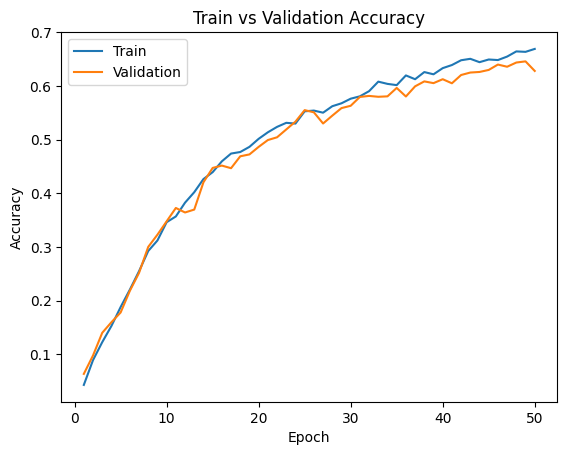

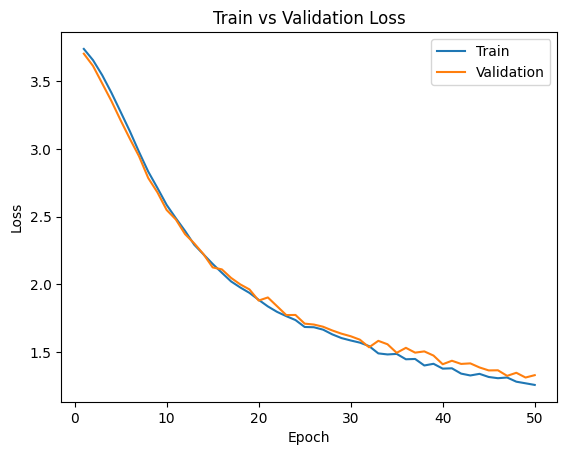

In [ ]:
path = get_model_name(baseline.name, batch, lr, epoch-1)
plot_training_curve(path)



---


# Confusion Matrix

In [53]:
def get_labels_and_predictions(model, loader, limit=3):
  labels_list = []
  predictions_list = []
  for i, data in enumerate(loader):
      if i == limit:
        break
      inputs, labels = data
      predictions = model(inputs)
      # print("start")
      # print(len(predictions.flatten()))
      # print("mid")
      # print(len(labels.flatten()))
      # print("end")
      labels_list += labels.flatten().tolist()
      predictions_list += predictions.tolist()
  return labels_list, predictions_list

In [45]:
_, cm_loader, _, cm_classes = get_data_loader(512)

best_baseline = Baseline()
best_path = get_model_name(best_baseline.name, batch_size=512, learning_rate=0.001, epoch=49)
state = torch.load(best_path)
best_baseline.load_state_dict(state)

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}
train_val_set size: 12330


<All keys matched successfully>

In [54]:
true, pred = get_labels_and_predictions(best_baseline, cm_loader)

In [55]:
len(true)

1536

In [59]:
len(pred)
pred
pred_labels = np.argmax(pred, axis=1)
pred_labels

array([39,  1,  6, ..., 17, 21,  7])

Confusion Matrix:
[[16  1  1 ...  0  0  0]
 [ 6 11  2 ...  0  0  0]
 [ 0  2 18 ...  0  1  0]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  1 ...  0 23  2]
 [ 0  0  0 ...  0  2 17]]


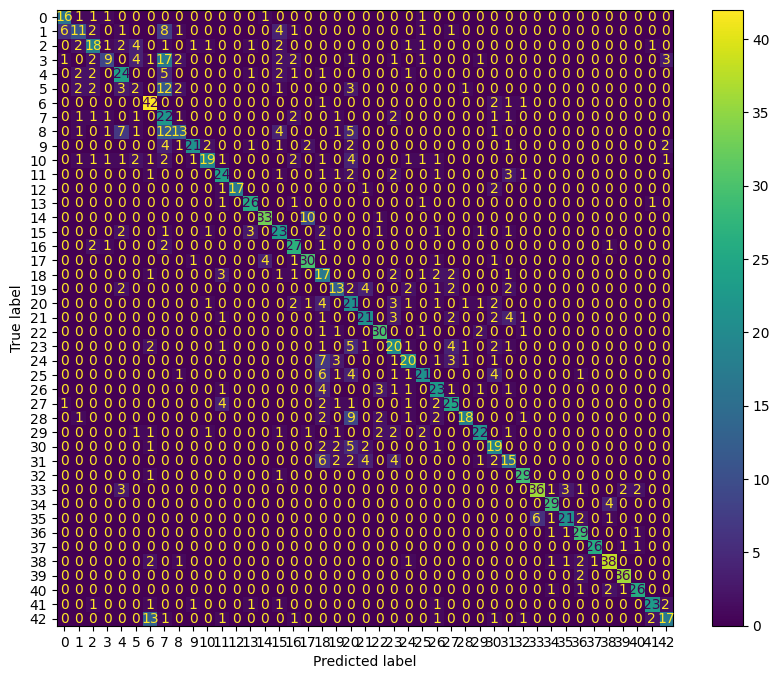

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, pred_labels)
print("Confusion Matrix:")
print(cm)


plt.figure(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_classes)
disp.plot(ax=plt.gca())
plt.show()